# BERT Fine-tuned

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [ ]:
#Step 1: Load Data

# Load the data
insample_df = pd.read_csv('insample_df.csv')
outsample_df = pd.read_csv('outsample_df.csv')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


insample_df sentiments shape: 40483
outsample_df sentiments shape: 28343
insample_df shape: (40483, 11)
outsample_df shape: (28343, 11)
Years available in the data: [2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018
 2019 2020 2021 2022 2023]


<ipython-input-7-f0ca55153a8f>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predicted_prob'] = y_prob
<ipython-input-7-f0ca55153a8f>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predicted_prob'] = y_prob
<ipython-input-7-f0ca55153a8f>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

Metrics for EW L:
Sharpe Ratio: -1.033256458061039

Metrics for EW S:
Sharpe Ratio: 14.809371888333825

Metrics for EW LS:
Sharpe Ratio: -12.813799331789467

Metrics for VW L:
Sharpe Ratio: 4.155610200722901

Metrics for VW S:
Sharpe Ratio: 18.6712912095501

Metrics for VW LS:
Sharpe Ratio: -14.506146217904238

Portfolio returns saved to 'BERTa_Finetune_portfolio_returns.csv'


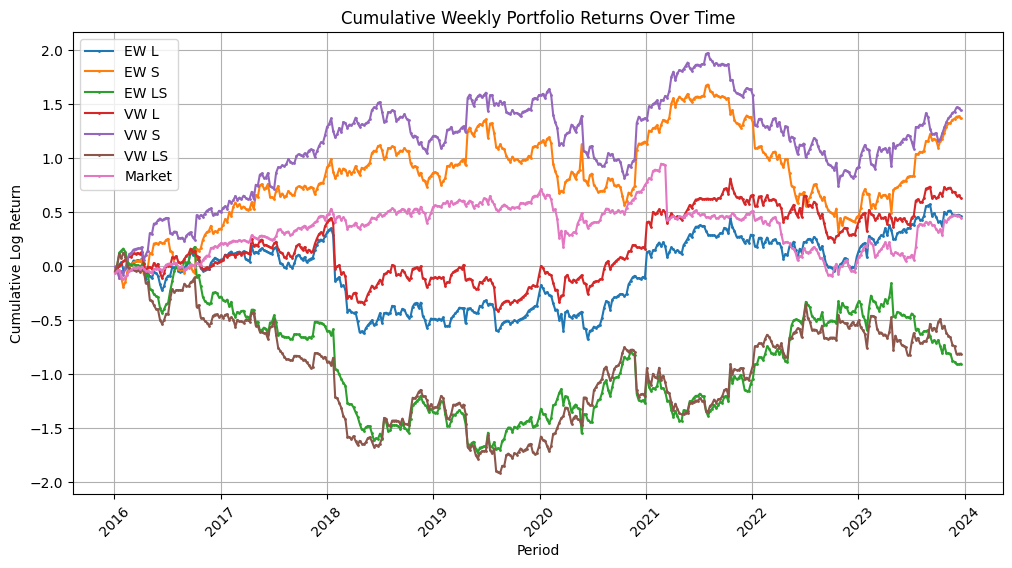

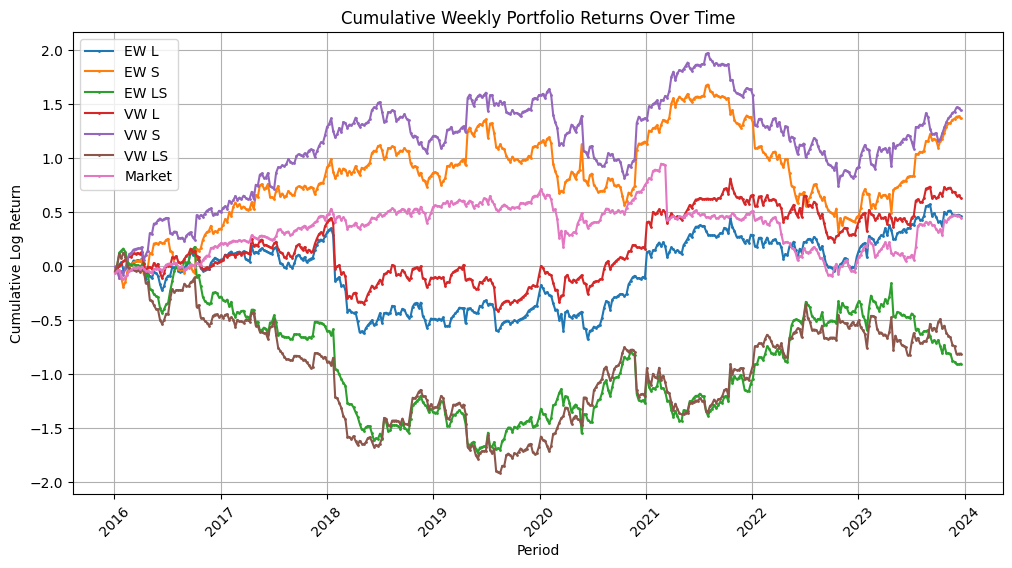

In [ ]:
# Step 4: Sentiment Analysis using Sequence Classifier

# Load the pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

# Function to predict sentiment
def predict_sentiment(text_list, batch_size=16):
    sentiments = []
    for i in range(0, len(text_list), batch_size):
        batch = text_list[i:i + batch_size]
        inputs = tokenizer(batch, return_tensors='pt', padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        batch_sentiments = torch.softmax(outputs.logits, dim=1)[:, 1].cpu().numpy()  # Probability of positive sentiment
        sentiments.extend(batch_sentiments)
    return sentiments

# Apply the function to predict sentiment for headlines
insample_df['sentiment'] = predict_sentiment(insample_df['headline'].tolist())
outsample_df['sentiment'] = predict_sentiment(outsample_df['headline'].tolist())

# Ensure sentiments are correctly formed and the same length as the input data
print(f"insample_df sentiments shape: {len(insample_df['sentiment'])}")
print(f"outsample_df sentiments shape: {len(outsample_df['sentiment'])}")
print(f"insample_df shape: {insample_df.shape}")
print(f"outsample_df shape: {outsample_df.shape}")

def prepare_data(insample_df, outsample_df):
    df = pd.concat([insample_df, outsample_df])
    df['Date From'] = pd.to_datetime(df['Date From'])
    df = df.sort_values(by='Date From')
    available_years = df['Date From'].dt.year.unique()
    print("Years available in the data:", available_years)
    return df

def rolling_window_analysis(df):
    companies = df['companyname'].unique()
    predictions_df = pd.DataFrame()

    for company in companies:
        company_df = df[df['companyname'] == company].copy()
        tscv = TimeSeriesSplit(n_splits=5)

        for train_index, test_index in tscv.split(company_df):
            train_df, test_df = company_df.iloc[train_index], company_df.iloc[test_index]

            if len(test_df) == 0 or len(train_df) == 0:
                continue

            X_test = test_df['sentiment'].values
            y_test = test_df['Future Return Direction'].values

            # Directly use sentiment probabilities for prediction
            y_prob = X_test  # Already the probability of positive sentiment

            if len(y_prob) != len(test_df):
                raise ValueError(f"Mismatch between test data length ({len(test_df)}) and predictions ({len(y_prob)})")

            test_df['predicted_prob'] = y_prob
            predictions_df = pd.concat([predictions_df, test_df[['Date From', 'companyname', 'predicted_prob', 'Weekly Compound Return']]], ignore_index=True)

    df = df.merge(predictions_df, on=['Date From', 'companyname', 'Weekly Compound Return'], how='left', suffixes=('', '_pred'))
    return df

def construct_portfolio(df, time_period='Week'):
    df['Date From'] = pd.to_datetime(df['Date From'])
    if time_period == 'Week':
        df['Period'] = df['Date From'].dt.to_period('W').dt.to_timestamp()
    else:
        raise ValueError("Invalid time_period. Use 'Week'.")

    portfolio_returns = []

    for period, group in df.groupby('Period'):
        if period.year < 2016:
            continue

        # Sort group by predicted_prob descending
        group_sorted = group.sort_values(by='predicted_prob', ascending=False)

        # Select top and bottom companies
        num_top_companies = 5
        num_bottom_companies = 5
        top_companies = group_sorted.head(num_top_companies)
        bottom_companies = group_sorted.tail(num_bottom_companies)

        # Equal-weighted returns
        long_return_eq = np.mean(np.log1p(top_companies['Weekly Compound Return']))
        short_return_eq = np.mean(np.log1p(bottom_companies['Weekly Compound Return']))
        long_short_return_eq = long_return_eq - short_return_eq

        # Value-weighted returns
        long_return_val = np.sum(np.log1p(top_companies['Weekly Compound Return']) * top_companies['market_cap']) / np.sum(top_companies['market_cap'])
        short_return_val = np.sum(np.log1p(bottom_companies['Weekly Compound Return']) * bottom_companies['market_cap']) / np.sum(bottom_companies['market_cap'])
        long_short_return_val = long_return_val - short_return_val

        portfolio_returns.append({
            'Period': period,
            'Long Return (Eq)': long_return_eq,
            'Short Return (Eq)': short_return_eq,
            'Long-Short Return (Eq)': long_short_return_eq,
            'Long Return (Val)': long_return_val,
            'Short Return (Val)': short_return_val,
            'Long-Short Return (Val)': long_short_return_val
        })

    portfolio_df = pd.DataFrame(portfolio_returns)
    portfolio_df['EW L'] = portfolio_df['Long Return (Eq)'].cumsum()
    portfolio_df['EW S'] = portfolio_df['Short Return (Eq)'].cumsum()
    portfolio_df['EW LS'] = portfolio_df['Long-Short Return (Eq)'].cumsum()
    portfolio_df['VW L'] = portfolio_df['Long Return (Val)'].cumsum()
    portfolio_df['VW S'] = portfolio_df['Short Return (Val)'].cumsum()
    portfolio_df['VW LS'] = portfolio_df['Long-Short Return (Val)'].cumsum()

    actual_returns = df[df['Date From'].dt.year >= 2016].groupby('Period')['Weekly Compound Return'].mean()
    actual_cumulative_returns = np.log1p(actual_returns).cumsum()
    portfolio_df = portfolio_df.merge(actual_cumulative_returns.rename('Market'), on='Period', how='left')

    metrics = {}
    for portfolio in ['EW L', 'EW S', 'EW LS', 'VW L', 'VW S', 'VW LS']:
        returns = portfolio_df[portfolio]

        if returns.isnull().all() or returns.eq(0).all():
            sharpe_ratio = np.nan
            max_drawdown = np.nan
            volatility = np.nan
        else:
            sharpe_ratio = returns.mean() / returns.std() * np.sqrt(52) if returns.std() != 0 else np.nan
            cumulative_returns = returns.cumsum()
            max_drawdown = (cumulative_returns.cummax() - cumulative_returns).max()
            volatility = returns.std() * np.sqrt(52)

        metrics[portfolio] = {
            'Sharpe Ratio': sharpe_ratio
        }

        print(f"Metrics for {portfolio}:")
        print(f"Sharpe Ratio: {sharpe_ratio}")
        print()

    portfolio_df.to_csv('BERTa_Finetune_portfolio_returns.csv', index=False)
    print("Portfolio returns saved to 'BERTa_Finetune_portfolio_returns.csv'")

    # Plotting portfolio returns
    plot_portfolio_returns(portfolio_df, title_suffix='Weekly')

    return portfolio_df

def plot_portfolio_returns(portfolio_df, title_suffix=''):
    plt.figure(figsize=(12, 6))

    plt.plot(portfolio_df['Period'], portfolio_df['EW L'], marker='o', markersize=1, label='EW L')
    plt.plot(portfolio_df['Period'], portfolio_df['EW S'], marker='o', markersize=1, label='EW S')
    plt.plot(portfolio_df['Period'], portfolio_df['EW LS'], marker='o', markersize=1, label='EW LS')
    plt.plot(portfolio_df['Period'], portfolio_df['VW L'], marker='o', markersize=1, label='VW L')
    plt.plot(portfolio_df['Period'], portfolio_df['VW S'], marker='o', markersize=1, label='VW S')
    plt.plot(portfolio_df['Period'], portfolio_df['VW LS'], marker='o', markersize=1, label='VW LS')
    plt.plot(portfolio_df['Period'], portfolio_df['Market'], marker='o', markersize=1, label='Market')

    plt.title(f'Cumulative {title_suffix} Portfolio Returns Over Time')
    plt.xlabel('Period')
    plt.ylabel('Cumulative Log Return')
    plt.legend()
    plt.grid(True)

    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xticks(rotation=45)
    plt.show()

# Example usage for Weekly
df = prepare_data(insample_df, outsample_df)
df = rolling_window_analysis(df)

# Weekly Portfolio
portfolio_df_week = construct_portfolio(df, time_period='Week')
portfolio_df_week = portfolio_df_week[portfolio_df_week['Period'].dt.year >= 2016]
plot_portfolio_returns(portfolio_df_week, title_suffix='Weekly')


# RoBERTa Fine-tuned

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


insample_df sentiments shape: 40483
outsample_df sentiments shape: 28343
insample_df shape: (40483, 11)
outsample_df shape: (28343, 11)
Years available in the data: [2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018
 2019 2020 2021 2022 2023]


<ipython-input-11-e3b63cb78513>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predicted_prob'] = y_prob
<ipython-input-11-e3b63cb78513>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predicted_prob'] = y_prob
<ipython-input-11-e3b63cb78513>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

Metrics for EW L:
Sharpe Ratio: 3.3910102625241274

Metrics for EW S:
Sharpe Ratio: -3.3468498052794917

Metrics for EW LS:
Sharpe Ratio: 4.3695362336274055

Metrics for VW L:
Sharpe Ratio: 11.667110297989378

Metrics for VW S:
Sharpe Ratio: -1.1260406960862324

Metrics for VW LS:
Sharpe Ratio: 6.350571516524036

Portfolio returns saved to 'RoBERTa_Finetune_portfolio_returns.csv'


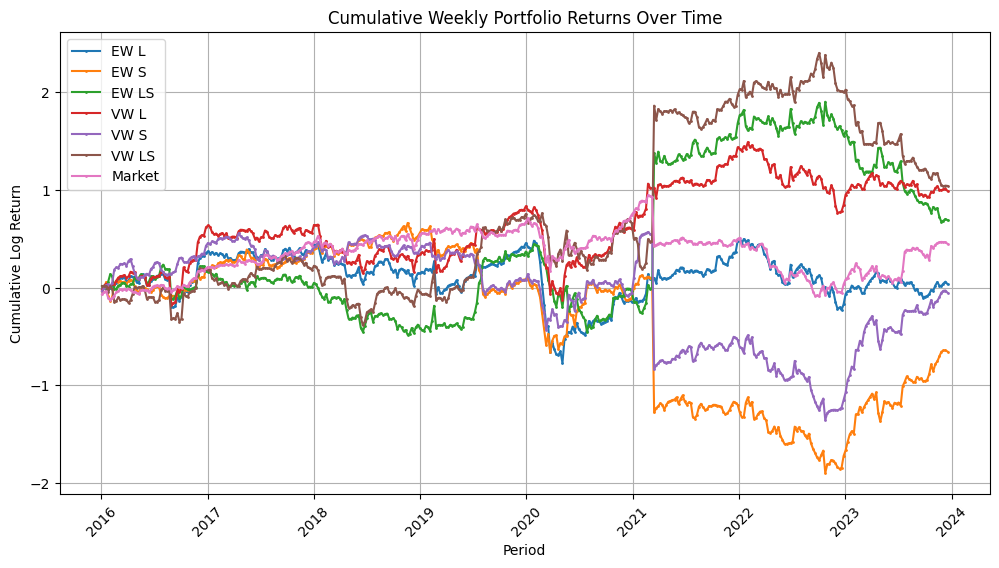

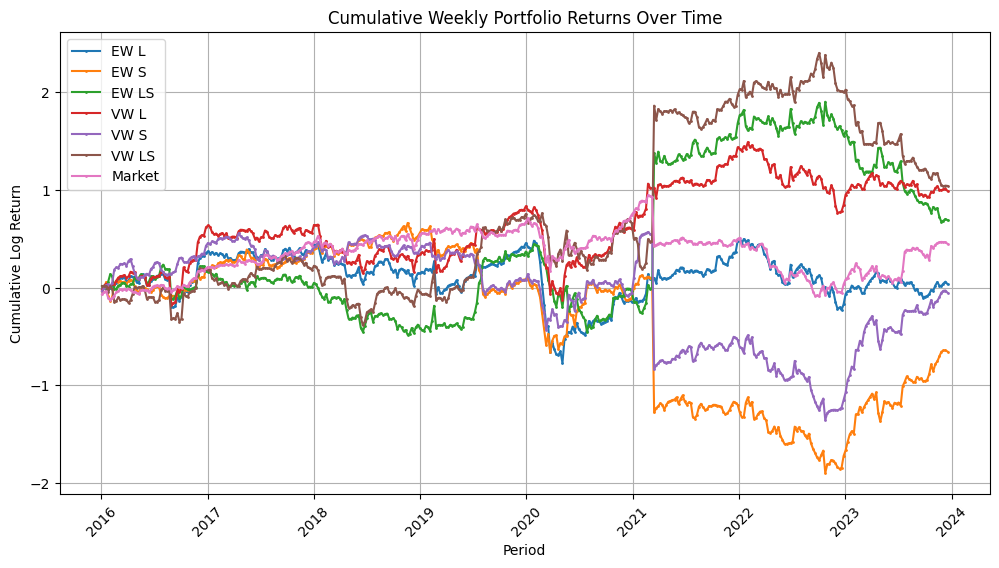

In [ ]:
from transformers import RobertaTokenizer, RobertaModel, RobertaForSequenceClassification

# Load the pre-trained BERT model and tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base')

# Function to predict sentiment
def predict_sentiment(text_list, batch_size=16):
    sentiments = []
    for i in range(0, len(text_list), batch_size):
        batch = text_list[i:i + batch_size]
        inputs = tokenizer(batch, return_tensors='pt', padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        batch_sentiments = torch.softmax(outputs.logits, dim=1)[:, 1].cpu().numpy()  # Probability of positive sentiment
        sentiments.extend(batch_sentiments)
    return sentiments

# Apply the function to predict sentiment for headlines
insample_df['sentiment'] = predict_sentiment(insample_df['headline'].tolist())
outsample_df['sentiment'] = predict_sentiment(outsample_df['headline'].tolist())

# Ensure sentiments are correctly formed and the same length as the input data
print(f"insample_df sentiments shape: {len(insample_df['sentiment'])}")
print(f"outsample_df sentiments shape: {len(outsample_df['sentiment'])}")
print(f"insample_df shape: {insample_df.shape}")
print(f"outsample_df shape: {outsample_df.shape}")

def prepare_data(insample_df, outsample_df):
    df = pd.concat([insample_df, outsample_df])
    df['Date From'] = pd.to_datetime(df['Date From'])
    df = df.sort_values(by='Date From')
    available_years = df['Date From'].dt.year.unique()
    print("Years available in the data:", available_years)
    return df

def rolling_window_analysis(df):
    companies = df['companyname'].unique()
    predictions_df = pd.DataFrame()

    for company in companies:
        company_df = df[df['companyname'] == company].copy()
        tscv = TimeSeriesSplit(n_splits=5)

        for train_index, test_index in tscv.split(company_df):
            train_df, test_df = company_df.iloc[train_index], company_df.iloc[test_index]

            if len(test_df) == 0 or len(train_df) == 0:
                continue

            X_test = test_df['sentiment'].values
            y_test = test_df['Future Return Direction'].values

            # Directly use sentiment probabilities for prediction
            y_prob = X_test  # Already the probability of positive sentiment

            if len(y_prob) != len(test_df):
                raise ValueError(f"Mismatch between test data length ({len(test_df)}) and predictions ({len(y_prob)})")

            test_df['predicted_prob'] = y_prob
            predictions_df = pd.concat([predictions_df, test_df[['Date From', 'companyname', 'predicted_prob', 'Weekly Compound Return']]], ignore_index=True)

    df = df.merge(predictions_df, on=['Date From', 'companyname', 'Weekly Compound Return'], how='left', suffixes=('', '_pred'))
    return df

def construct_portfolio(df, time_period='Week'):
    df['Date From'] = pd.to_datetime(df['Date From'])
    if time_period == 'Week':
        df['Period'] = df['Date From'].dt.to_period('W').dt.to_timestamp()
    else:
        raise ValueError("Invalid time_period. Use 'Week'.")

    portfolio_returns = []

    for period, group in df.groupby('Period'):
        if period.year < 2016:
            continue

        # Sort group by predicted_prob descending
        group_sorted = group.sort_values(by='predicted_prob', ascending=False)

        # Select top and bottom companies
        num_top_companies = 5
        num_bottom_companies = 5
        top_companies = group_sorted.head(num_top_companies)
        bottom_companies = group_sorted.tail(num_bottom_companies)

        # Equal-weighted returns
        long_return_eq = np.mean(np.log1p(top_companies['Weekly Compound Return']))
        short_return_eq = np.mean(np.log1p(bottom_companies['Weekly Compound Return']))
        long_short_return_eq = long_return_eq - short_return_eq

        # Value-weighted returns
        long_return_val = np.sum(np.log1p(top_companies['Weekly Compound Return']) * top_companies['market_cap']) / np.sum(top_companies['market_cap'])
        short_return_val = np.sum(np.log1p(bottom_companies['Weekly Compound Return']) * bottom_companies['market_cap']) / np.sum(bottom_companies['market_cap'])
        long_short_return_val = long_return_val - short_return_val

        portfolio_returns.append({
            'Period': period,
            'Long Return (Eq)': long_return_eq,
            'Short Return (Eq)': short_return_eq,
            'Long-Short Return (Eq)': long_short_return_eq,
            'Long Return (Val)': long_return_val,
            'Short Return (Val)': short_return_val,
            'Long-Short Return (Val)': long_short_return_val
        })

    portfolio_df = pd.DataFrame(portfolio_returns)
    portfolio_df['EW L'] = portfolio_df['Long Return (Eq)'].cumsum()
    portfolio_df['EW S'] = portfolio_df['Short Return (Eq)'].cumsum()
    portfolio_df['EW LS'] = portfolio_df['Long-Short Return (Eq)'].cumsum()
    portfolio_df['VW L'] = portfolio_df['Long Return (Val)'].cumsum()
    portfolio_df['VW S'] = portfolio_df['Short Return (Val)'].cumsum()
    portfolio_df['VW LS'] = portfolio_df['Long-Short Return (Val)'].cumsum()

    actual_returns = df[df['Date From'].dt.year >= 2016].groupby('Period')['Weekly Compound Return'].mean()
    actual_cumulative_returns = np.log1p(actual_returns).cumsum()
    portfolio_df = portfolio_df.merge(actual_cumulative_returns.rename('Market'), on='Period', how='left')

    metrics = {}
    for portfolio in ['EW L', 'EW S', 'EW LS', 'VW L', 'VW S', 'VW LS']:
        returns = portfolio_df[portfolio]

        if returns.isnull().all() or returns.eq(0).all():
            sharpe_ratio = np.nan
            max_drawdown = np.nan
            volatility = np.nan
        else:
            sharpe_ratio = returns.mean() / returns.std() * np.sqrt(52) if returns.std() != 0 else np.nan
            cumulative_returns = returns.cumsum()
            max_drawdown = (cumulative_returns.cummax() - cumulative_returns).max()
            volatility = returns.std() * np.sqrt(52)

        metrics[portfolio] = {
            'Sharpe Ratio': sharpe_ratio
        }

        print(f"Metrics for {portfolio}:")
        print(f"Sharpe Ratio: {sharpe_ratio}")
        print()

    portfolio_df.to_csv('RoBERTa_Finetune_portfolio_returns.csv', index=False)
    print("Portfolio returns saved to 'RoBERTa_Finetune_portfolio_returns.csv'")

    # Plotting portfolio returns
    plot_portfolio_returns(portfolio_df, title_suffix='Weekly')

    return portfolio_df

def plot_portfolio_returns(portfolio_df, title_suffix=''):
    plt.figure(figsize=(12, 6))

    plt.plot(portfolio_df['Period'], portfolio_df['EW L'], marker='o', markersize=1, label='EW L')
    plt.plot(portfolio_df['Period'], portfolio_df['EW S'], marker='o', markersize=1, label='EW S')
    plt.plot(portfolio_df['Period'], portfolio_df['EW LS'], marker='o', markersize=1, label='EW LS')
    plt.plot(portfolio_df['Period'], portfolio_df['VW L'], marker='o', markersize=1, label='VW L')
    plt.plot(portfolio_df['Period'], portfolio_df['VW S'], marker='o', markersize=1, label='VW S')
    plt.plot(portfolio_df['Period'], portfolio_df['VW LS'], marker='o', markersize=1, label='VW LS')
    plt.plot(portfolio_df['Period'], portfolio_df['Market'], marker='o', markersize=1, label='Market')

    plt.title(f'Cumulative {title_suffix} Portfolio Returns Over Time')
    plt.xlabel('Period')
    plt.ylabel('Cumulative Log Return')
    plt.legend()
    plt.grid(True)

    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xticks(rotation=45)
    plt.show()

# Example usage for Weekly
df = prepare_data(insample_df, outsample_df)
df = rolling_window_analysis(df)

# Weekly Portfolio
portfolio_df_week = construct_portfolio(df, time_period='Week')
portfolio_df_week = portfolio_df_week[portfolio_df_week['Period'].dt.year >= 2016]
plot_portfolio_returns(portfolio_df_week, title_suffix='Weekly')


# Distil BERT Fine-tuned

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


insample_df sentiments shape: 40483
outsample_df sentiments shape: 28343
insample_df shape: (40483, 11)
outsample_df shape: (28343, 11)
Years available in the data: [2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018
 2019 2020 2021 2022 2023]


<ipython-input-10-47425e1e3b5c>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predicted_prob'] = y_prob
<ipython-input-10-47425e1e3b5c>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predicted_prob'] = y_prob
<ipython-input-10-47425e1e3b5c>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

Metrics for EW L:
Sharpe Ratio: 11.979536186379129

Metrics for EW S:
Sharpe Ratio: 19.77281747376239

Metrics for EW LS:
Sharpe Ratio: -12.554444237013751

Metrics for VW L:
Sharpe Ratio: 9.553983932031608

Metrics for VW S:
Sharpe Ratio: 15.964619906444996

Metrics for VW LS:
Sharpe Ratio: -5.481838388958695

Portfolio returns saved to 'DistilBERT_Finetune_portfolio_returns.csv'


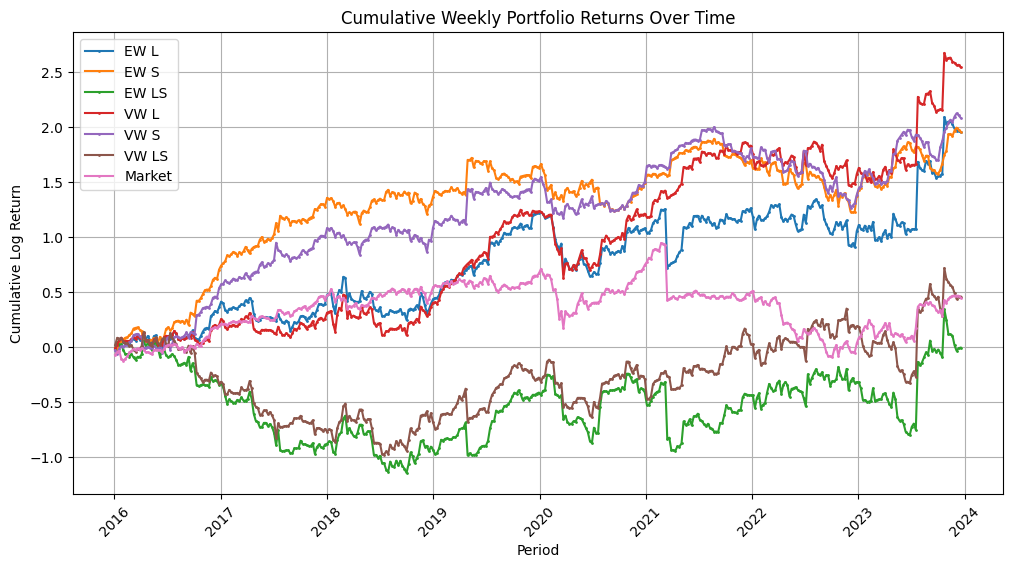

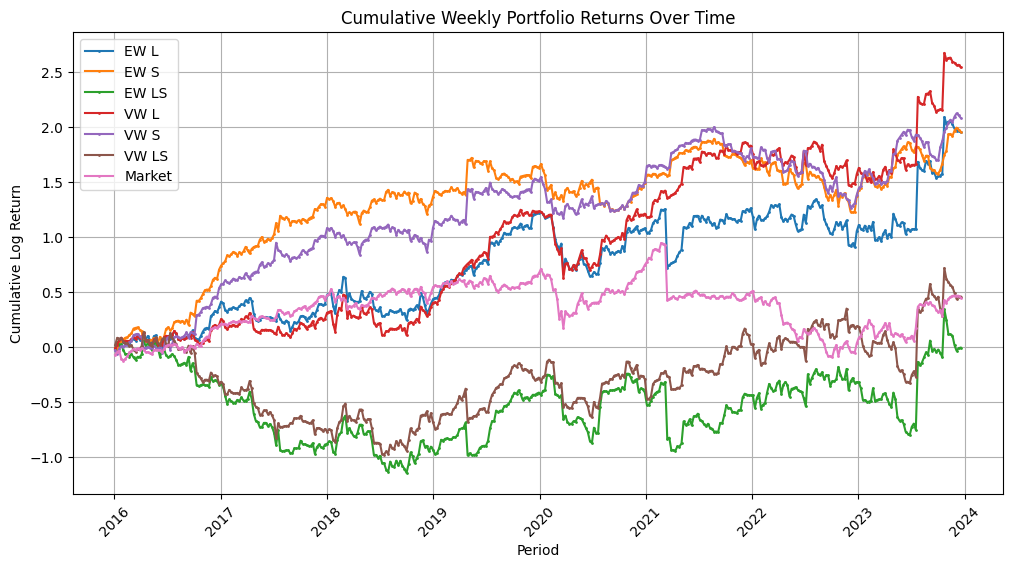

In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# Load the pre-trained BERT model and tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

# Function to predict sentiment
def predict_sentiment(text_list, batch_size=16):
    sentiments = []
    for i in range(0, len(text_list), batch_size):
        batch = text_list[i:i + batch_size]
        inputs = tokenizer(batch, return_tensors='pt', padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        batch_sentiments = torch.softmax(outputs.logits, dim=1)[:, 1].cpu().numpy()  # Probability of positive sentiment
        sentiments.extend(batch_sentiments)
    return sentiments

# Apply the function to predict sentiment for headlines
insample_df['sentiment'] = predict_sentiment(insample_df['headline'].tolist())
outsample_df['sentiment'] = predict_sentiment(outsample_df['headline'].tolist())

# Ensure sentiments are correctly formed and the same length as the input data
print(f"insample_df sentiments shape: {len(insample_df['sentiment'])}")
print(f"outsample_df sentiments shape: {len(outsample_df['sentiment'])}")
print(f"insample_df shape: {insample_df.shape}")
print(f"outsample_df shape: {outsample_df.shape}")

def prepare_data(insample_df, outsample_df):
    df = pd.concat([insample_df, outsample_df])
    df['Date From'] = pd.to_datetime(df['Date From'])
    df = df.sort_values(by='Date From')
    available_years = df['Date From'].dt.year.unique()
    print("Years available in the data:", available_years)
    return df

def rolling_window_analysis(df):
    companies = df['companyname'].unique()
    predictions_df = pd.DataFrame()

    for company in companies:
        company_df = df[df['companyname'] == company].copy()
        tscv = TimeSeriesSplit(n_splits=5)

        for train_index, test_index in tscv.split(company_df):
            train_df, test_df = company_df.iloc[train_index], company_df.iloc[test_index]

            if len(test_df) == 0 or len(train_df) == 0:
                continue

            X_test = test_df['sentiment'].values
            y_test = test_df['Future Return Direction'].values

            # Directly use sentiment probabilities for prediction
            y_prob = X_test  # Already the probability of positive sentiment

            if len(y_prob) != len(test_df):
                raise ValueError(f"Mismatch between test data length ({len(test_df)}) and predictions ({len(y_prob)})")

            test_df['predicted_prob'] = y_prob
            predictions_df = pd.concat([predictions_df, test_df[['Date From', 'companyname', 'predicted_prob', 'Weekly Compound Return']]], ignore_index=True)

    df = df.merge(predictions_df, on=['Date From', 'companyname', 'Weekly Compound Return'], how='left', suffixes=('', '_pred'))
    return df

def construct_portfolio(df, time_period='Week'):
    df['Date From'] = pd.to_datetime(df['Date From'])
    if time_period == 'Week':
        df['Period'] = df['Date From'].dt.to_period('W').dt.to_timestamp()
    else:
        raise ValueError("Invalid time_period. Use 'Week'.")

    portfolio_returns = []

    for period, group in df.groupby('Period'):
        if period.year < 2016:
            continue

        # Sort group by predicted_prob descending
        group_sorted = group.sort_values(by='predicted_prob', ascending=False)

        # Select top and bottom companies
        num_top_companies = 5
        num_bottom_companies = 5
        top_companies = group_sorted.head(num_top_companies)
        bottom_companies = group_sorted.tail(num_bottom_companies)

        # Equal-weighted returns
        long_return_eq = np.mean(np.log1p(top_companies['Weekly Compound Return']))
        short_return_eq = np.mean(np.log1p(bottom_companies['Weekly Compound Return']))
        long_short_return_eq = long_return_eq - short_return_eq

        # Value-weighted returns
        long_return_val = np.sum(np.log1p(top_companies['Weekly Compound Return']) * top_companies['market_cap']) / np.sum(top_companies['market_cap'])
        short_return_val = np.sum(np.log1p(bottom_companies['Weekly Compound Return']) * bottom_companies['market_cap']) / np.sum(bottom_companies['market_cap'])
        long_short_return_val = long_return_val - short_return_val

        portfolio_returns.append({
            'Period': period,
            'Long Return (Eq)': long_return_eq,
            'Short Return (Eq)': short_return_eq,
            'Long-Short Return (Eq)': long_short_return_eq,
            'Long Return (Val)': long_return_val,
            'Short Return (Val)': short_return_val,
            'Long-Short Return (Val)': long_short_return_val
        })

    portfolio_df = pd.DataFrame(portfolio_returns)
    portfolio_df['EW L'] = portfolio_df['Long Return (Eq)'].cumsum()
    portfolio_df['EW S'] = portfolio_df['Short Return (Eq)'].cumsum()
    portfolio_df['EW LS'] = portfolio_df['Long-Short Return (Eq)'].cumsum()
    portfolio_df['VW L'] = portfolio_df['Long Return (Val)'].cumsum()
    portfolio_df['VW S'] = portfolio_df['Short Return (Val)'].cumsum()
    portfolio_df['VW LS'] = portfolio_df['Long-Short Return (Val)'].cumsum()

    actual_returns = df[df['Date From'].dt.year >= 2016].groupby('Period')['Weekly Compound Return'].mean()
    actual_cumulative_returns = np.log1p(actual_returns).cumsum()
    portfolio_df = portfolio_df.merge(actual_cumulative_returns.rename('Market'), on='Period', how='left')

    metrics = {}
    for portfolio in ['EW L', 'EW S', 'EW LS', 'VW L', 'VW S', 'VW LS']:
        returns = portfolio_df[portfolio]

        if returns.isnull().all() or returns.eq(0).all():
            sharpe_ratio = np.nan
            max_drawdown = np.nan
            volatility = np.nan
        else:
            sharpe_ratio = returns.mean() / returns.std() * np.sqrt(52) if returns.std() != 0 else np.nan
            cumulative_returns = returns.cumsum()
            max_drawdown = (cumulative_returns.cummax() - cumulative_returns).max()
            volatility = returns.std() * np.sqrt(52)

        metrics[portfolio] = {
            'Sharpe Ratio': sharpe_ratio
        }

        print(f"Metrics for {portfolio}:")
        print(f"Sharpe Ratio: {sharpe_ratio}")
        print()

    portfolio_df.to_csv('DistilBERT_Finetune_portfolio_returns.csv', index=False)
    print("Portfolio returns saved to 'DistilBERT_Finetune_portfolio_returns.csv'")

    # Plotting portfolio returns
    plot_portfolio_returns(portfolio_df, title_suffix='Weekly')

    return portfolio_df

def plot_portfolio_returns(portfolio_df, title_suffix=''):
    plt.figure(figsize=(12, 6))

    plt.plot(portfolio_df['Period'], portfolio_df['EW L'], marker='o', markersize=1, label='EW L')
    plt.plot(portfolio_df['Period'], portfolio_df['EW S'], marker='o', markersize=1, label='EW S')
    plt.plot(portfolio_df['Period'], portfolio_df['EW LS'], marker='o', markersize=1, label='EW LS')
    plt.plot(portfolio_df['Period'], portfolio_df['VW L'], marker='o', markersize=1, label='VW L')
    plt.plot(portfolio_df['Period'], portfolio_df['VW S'], marker='o', markersize=1, label='VW S')
    plt.plot(portfolio_df['Period'], portfolio_df['VW LS'], marker='o', markersize=1, label='VW LS')
    plt.plot(portfolio_df['Period'], portfolio_df['Market'], marker='o', markersize=1, label='Market')

    plt.title(f'Cumulative {title_suffix} Portfolio Returns Over Time')
    plt.xlabel('Period')
    plt.ylabel('Cumulative Log Return')
    plt.legend()
    plt.grid(True)

    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xticks(rotation=45)
    plt.show()

# Example usage for Weekly
df = prepare_data(insample_df, outsample_df)
df = rolling_window_analysis(df)

# Weekly Portfolio
portfolio_df_week = construct_portfolio(df, time_period='Week')
portfolio_df_week = portfolio_df_week[portfolio_df_week['Period'].dt.year >= 2016]
plot_portfolio_returns(portfolio_df_week, title_suffix='Weekly')

# Distil RoBERTa Fine-tuned

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


insample_df sentiments shape: 40483
outsample_df sentiments shape: 28343
insample_df shape: (40483, 11)
outsample_df shape: (28343, 11)
Years available in the data: [2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018
 2019 2020 2021 2022 2023]


<ipython-input-8-66c373f46928>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predicted_prob'] = y_prob
<ipython-input-8-66c373f46928>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predicted_prob'] = y_prob
<ipython-input-8-66c373f46928>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

Metrics for EW L:
Sharpe Ratio: -12.636317054156269

Metrics for EW S:
Sharpe Ratio: -0.37700692592799356

Metrics for EW LS:
Sharpe Ratio: -3.7984193712081216

Metrics for VW L:
Sharpe Ratio: -0.8041934949089945

Metrics for VW S:
Sharpe Ratio: -2.228610029669353

Metrics for VW LS:
Sharpe Ratio: 1.7833429464245714

Portfolio returns saved to 'DistilRoBERTa_Finetune_portfolio_returns.csv'


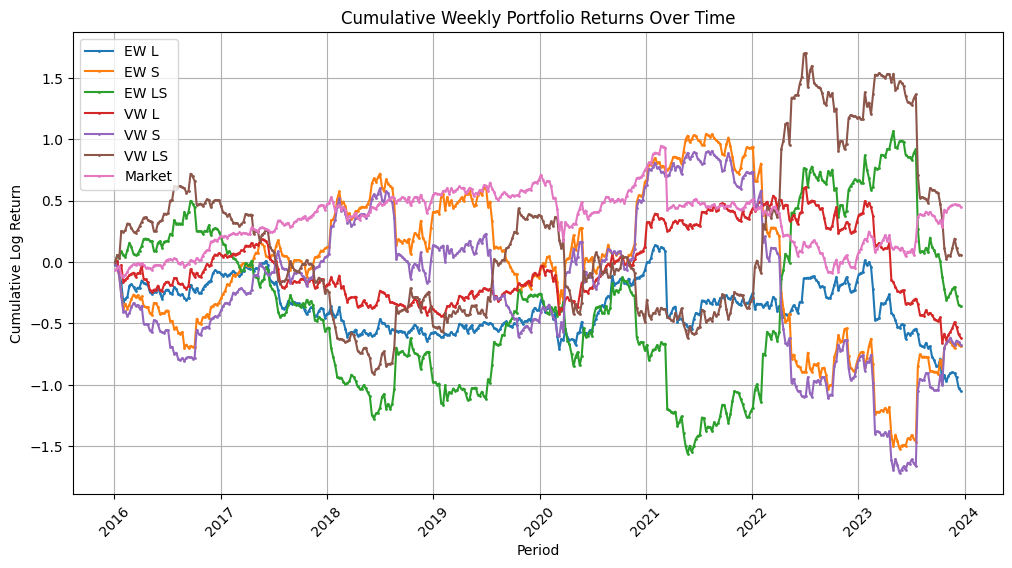

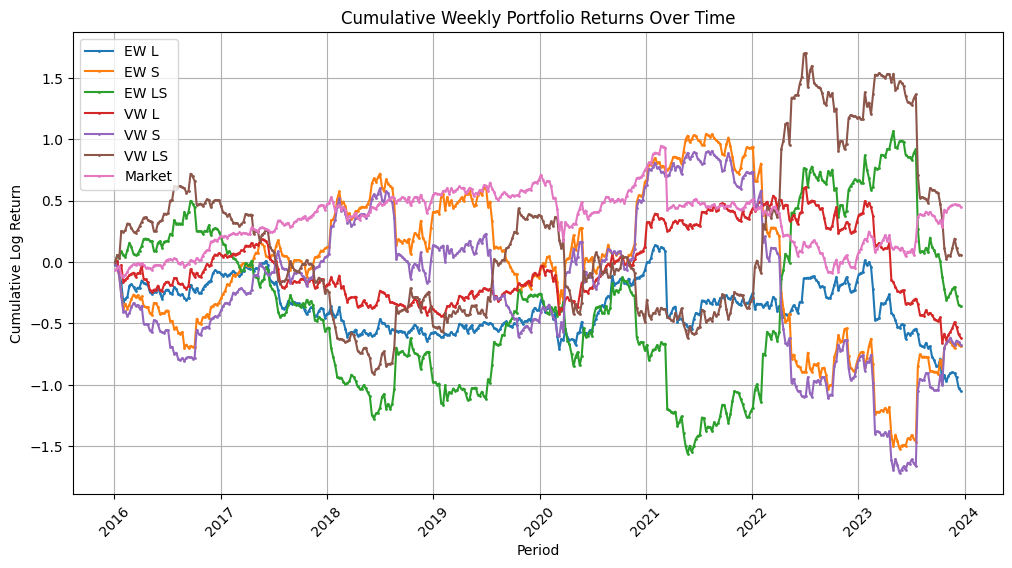

In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification

# Load the pre-trained DistilRoBERTa model and tokenizer
tokenizer = RobertaTokenizer.from_pretrained('distilroberta-base')
model = RobertaForSequenceClassification.from_pretrained('distilroberta-base')

# Function to predict sentiment
def predict_sentiment(text_list, batch_size=16):
    sentiments = []
    for i in range(0, len(text_list), batch_size):
        batch = text_list[i:i + batch_size]
        inputs = tokenizer(batch, return_tensors='pt', padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        batch_sentiments = torch.softmax(outputs.logits, dim=1)[:, 1].cpu().numpy()  # Probability of positive sentiment
        sentiments.extend(batch_sentiments)
    return sentiments

# Apply the function to predict sentiment for headlines
insample_df['sentiment'] = predict_sentiment(insample_df['headline'].tolist())
outsample_df['sentiment'] = predict_sentiment(outsample_df['headline'].tolist())

# Ensure sentiments are correctly formed and the same length as the input data
print(f"insample_df sentiments shape: {len(insample_df['sentiment'])}")
print(f"outsample_df sentiments shape: {len(outsample_df['sentiment'])}")
print(f"insample_df shape: {insample_df.shape}")
print(f"outsample_df shape: {outsample_df.shape}")

def prepare_data(insample_df, outsample_df):
    df = pd.concat([insample_df, outsample_df])
    df['Date From'] = pd.to_datetime(df['Date From'])
    df = df.sort_values(by='Date From')
    available_years = df['Date From'].dt.year.unique()
    print("Years available in the data:", available_years)
    return df

def rolling_window_analysis(df):
    companies = df['companyname'].unique()
    predictions_df = pd.DataFrame()

    for company in companies:
        company_df = df[df['companyname'] == company].copy()
        tscv = TimeSeriesSplit(n_splits=5)

        for train_index, test_index in tscv.split(company_df):
            train_df, test_df = company_df.iloc[train_index], company_df.iloc[test_index]

            if len(test_df) == 0 or len(train_df) == 0:
                continue

            X_test = test_df['sentiment'].values
            y_test = test_df['Future Return Direction'].values

            # Directly use sentiment probabilities for prediction
            y_prob = X_test  # Already the probability of positive sentiment

            if len(y_prob) != len(test_df):
                raise ValueError(f"Mismatch between test data length ({len(test_df)}) and predictions ({len(y_prob)})")

            test_df['predicted_prob'] = y_prob
            predictions_df = pd.concat([predictions_df, test_df[['Date From', 'companyname', 'predicted_prob', 'Weekly Compound Return']]], ignore_index=True)

    df = df.merge(predictions_df, on=['Date From', 'companyname', 'Weekly Compound Return'], how='left', suffixes=('', '_pred'))
    return df

def construct_portfolio(df, time_period='Week'):
    df['Date From'] = pd.to_datetime(df['Date From'])
    if time_period == 'Week':
        df['Period'] = df['Date From'].dt.to_period('W').dt.to_timestamp()
    else:
        raise ValueError("Invalid time_period. Use 'Week'.")

    portfolio_returns = []

    for period, group in df.groupby('Period'):
        if period.year < 2016:
            continue

        # Sort group by predicted_prob descending
        group_sorted = group.sort_values(by='predicted_prob', ascending=False)

        # Select top and bottom companies
        num_top_companies = 5
        num_bottom_companies = 5
        top_companies = group_sorted.head(num_top_companies)
        bottom_companies = group_sorted.tail(num_bottom_companies)

        # Equal-weighted returns
        long_return_eq = np.mean(np.log1p(top_companies['Weekly Compound Return']))
        short_return_eq = np.mean(np.log1p(bottom_companies['Weekly Compound Return']))
        long_short_return_eq = long_return_eq - short_return_eq

        # Value-weighted returns
        long_return_val = np.sum(np.log1p(top_companies['Weekly Compound Return']) * top_companies['market_cap']) / np.sum(top_companies['market_cap'])
        short_return_val = np.sum(np.log1p(bottom_companies['Weekly Compound Return']) * bottom_companies['market_cap']) / np.sum(bottom_companies['market_cap'])
        long_short_return_val = long_return_val - short_return_val

        portfolio_returns.append({
            'Period': period,
            'Long Return (Eq)': long_return_eq,
            'Short Return (Eq)': short_return_eq,
            'Long-Short Return (Eq)': long_short_return_eq,
            'Long Return (Val)': long_return_val,
            'Short Return (Val)': short_return_val,
            'Long-Short Return (Val)': long_short_return_val
        })

    portfolio_df = pd.DataFrame(portfolio_returns)
    portfolio_df['EW L'] = portfolio_df['Long Return (Eq)'].cumsum()
    portfolio_df['EW S'] = portfolio_df['Short Return (Eq)'].cumsum()
    portfolio_df['EW LS'] = portfolio_df['Long-Short Return (Eq)'].cumsum()
    portfolio_df['VW L'] = portfolio_df['Long Return (Val)'].cumsum()
    portfolio_df['VW S'] = portfolio_df['Short Return (Val)'].cumsum()
    portfolio_df['VW LS'] = portfolio_df['Long-Short Return (Val)'].cumsum()

    actual_returns = df[df['Date From'].dt.year >= 2016].groupby('Period')['Weekly Compound Return'].mean()
    actual_cumulative_returns = np.log1p(actual_returns).cumsum()
    portfolio_df = portfolio_df.merge(actual_cumulative_returns.rename('Market'), on='Period', how='left')

    metrics = {}
    for portfolio in ['EW L', 'EW S', 'EW LS', 'VW L', 'VW S', 'VW LS']:
        returns = portfolio_df[portfolio]

        if returns.isnull().all() or returns.eq(0).all():
            sharpe_ratio = np.nan
            max_drawdown = np.nan
            volatility = np.nan
        else:
            sharpe_ratio = returns.mean() / returns.std() * np.sqrt(52) if returns.std() != 0 else np.nan
            cumulative_returns = returns.cumsum()
            max_drawdown = (cumulative_returns.cummax() - cumulative_returns).max()
            volatility = returns.std() * np.sqrt(52)

        metrics[portfolio] = {
            'Sharpe Ratio': sharpe_ratio
        }

        print(f"Metrics for {portfolio}:")
        print(f"Sharpe Ratio: {sharpe_ratio}")
        print()

    portfolio_df.to_csv('DistilRoBERTa_Finetune_portfolio_returns.csv', index=False)
    print("Portfolio returns saved to 'DistilRoBERTa_Finetune_portfolio_returns.csv'")

    # Plotting portfolio returns
    plot_portfolio_returns(portfolio_df, title_suffix='Weekly')

    return portfolio_df

def plot_portfolio_returns(portfolio_df, title_suffix=''):
    plt.figure(figsize=(12, 6))

    plt.plot(portfolio_df['Period'], portfolio_df['EW L'], marker='o', markersize=1, label='EW L')
    plt.plot(portfolio_df['Period'], portfolio_df['EW S'], marker='o', markersize=1, label='EW S')
    plt.plot(portfolio_df['Period'], portfolio_df['EW LS'], marker='o', markersize=1, label='EW LS')
    plt.plot(portfolio_df['Period'], portfolio_df['VW L'], marker='o', markersize=1, label='VW L')
    plt.plot(portfolio_df['Period'], portfolio_df['VW S'], marker='o', markersize=1, label='VW S')
    plt.plot(portfolio_df['Period'], portfolio_df['VW LS'], marker='o', markersize=1, label='VW LS')
    plt.plot(portfolio_df['Period'], portfolio_df['Market'], marker='o', markersize=1, label='Market')

    plt.title(f'Cumulative {title_suffix} Portfolio Returns Over Time')
    plt.xlabel('Period')
    plt.ylabel('Cumulative Log Return')
    plt.legend()
    plt.grid(True)

    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xticks(rotation=45)
    plt.show()

# Example usage for Weekly
df = prepare_data(insample_df, outsample_df)
df = rolling_window_analysis(df)

# Weekly Portfolio
portfolio_df_week = construct_portfolio(df, time_period='Week')
portfolio_df_week = portfolio_df_week[portfolio_df_week['Period'].dt.year >= 2016]
plot_portfolio_returns(portfolio_df_week, title_suffix='Weekly')


# FinBERT Fine-tuned

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


insample_df sentiments shape: 40483
outsample_df sentiments shape: 28343
insample_df shape: (40483, 11)
outsample_df shape: (28343, 11)
Years available in the data: [2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018
 2019 2020 2021 2022 2023]


<ipython-input-9-09048d032e7a>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predicted_prob'] = y_prob
<ipython-input-9-09048d032e7a>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predicted_prob'] = y_prob
<ipython-input-9-09048d032e7a>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

Metrics for EW L:
Sharpe Ratio: -2.8392504694658847

Metrics for EW S:
Sharpe Ratio: 9.663551126492292

Metrics for EW LS:
Sharpe Ratio: -8.661983185043832

Metrics for VW L:
Sharpe Ratio: -8.546925813886252

Metrics for VW S:
Sharpe Ratio: 12.332688282066536

Metrics for VW LS:
Sharpe Ratio: -11.51272529269148

Portfolio returns saved to 'FinBERT_Finetune_portfolio_returns.csv'


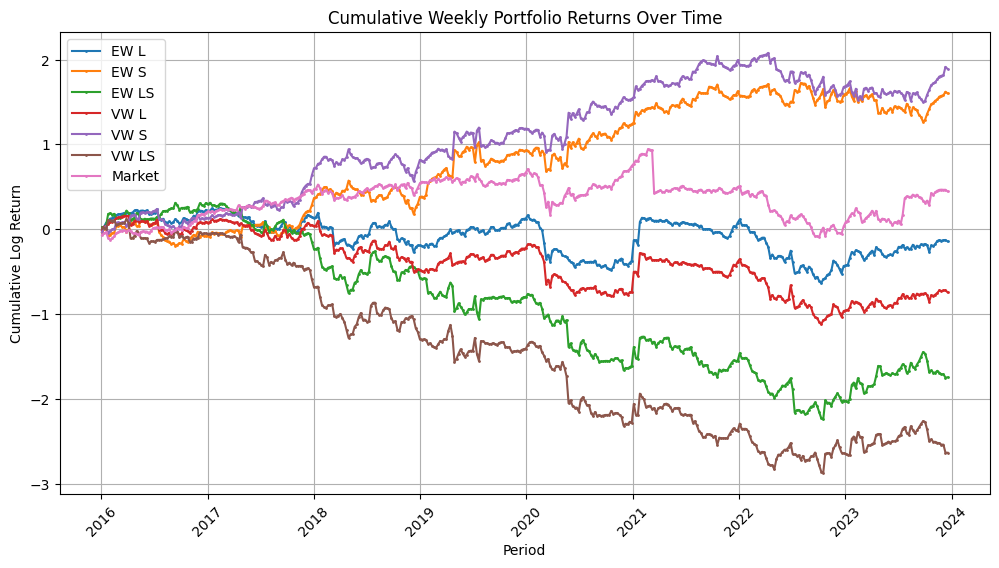

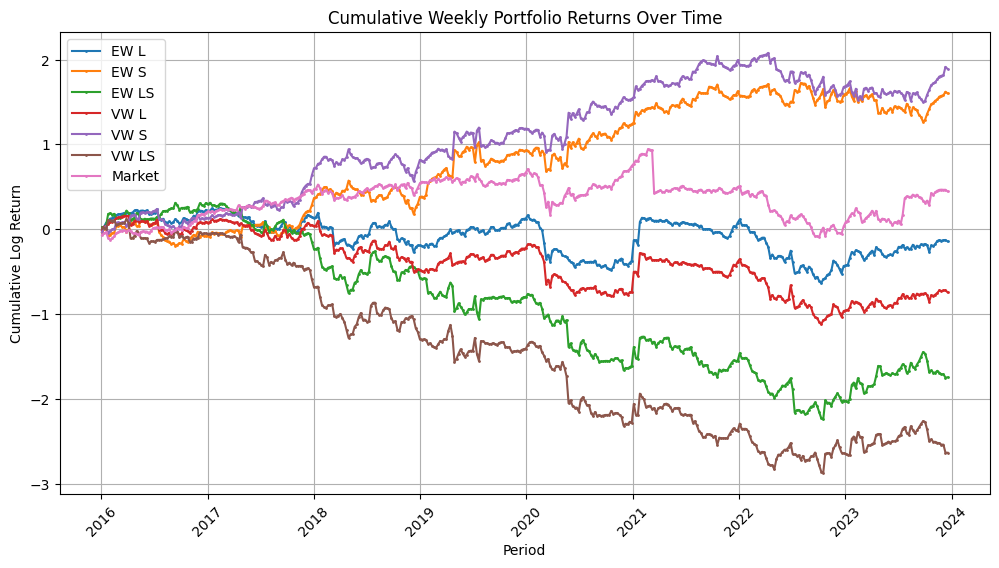

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load the pre-trained FinBERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('yiyanghkust/finbert-tone', use_fast=False)
model = AutoModelForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone')

# Function to predict sentiment
def predict_sentiment(text_list, batch_size=16):
    sentiments = []
    for i in range(0, len(text_list), batch_size):
        batch = text_list[i:i + batch_size]
        inputs = tokenizer(batch, return_tensors='pt', padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        batch_sentiments = torch.softmax(outputs.logits, dim=1)[:, 1].cpu().numpy()  # Probability of positive sentiment
        sentiments.extend(batch_sentiments)
    return sentiments

# Apply the function to predict sentiment for headlines
insample_df['sentiment'] = predict_sentiment(insample_df['headline'].tolist())
outsample_df['sentiment'] = predict_sentiment(outsample_df['headline'].tolist())

# Ensure sentiments are correctly formed and the same length as the input data
print(f"insample_df sentiments shape: {len(insample_df['sentiment'])}")
print(f"outsample_df sentiments shape: {len(outsample_df['sentiment'])}")
print(f"insample_df shape: {insample_df.shape}")
print(f"outsample_df shape: {outsample_df.shape}")

def prepare_data(insample_df, outsample_df):
    df = pd.concat([insample_df, outsample_df])
    df['Date From'] = pd.to_datetime(df['Date From'])
    df = df.sort_values(by='Date From')
    available_years = df['Date From'].dt.year.unique()
    print("Years available in the data:", available_years)
    return df

def rolling_window_analysis(df):
    companies = df['companyname'].unique()
    predictions_df = pd.DataFrame()

    for company in companies:
        company_df = df[df['companyname'] == company].copy()
        tscv = TimeSeriesSplit(n_splits=5)

        for train_index, test_index in tscv.split(company_df):
            train_df, test_df = company_df.iloc[train_index], company_df.iloc[test_index]

            if len(test_df) == 0 or len(train_df) == 0:
                continue

            X_test = test_df['sentiment'].values
            y_test = test_df['Future Return Direction'].values

            # Directly use sentiment probabilities for prediction
            y_prob = X_test  # Already the probability of positive sentiment

            if len(y_prob) != len(test_df):
                raise ValueError(f"Mismatch between test data length ({len(test_df)}) and predictions ({len(y_prob)})")

            test_df['predicted_prob'] = y_prob
            predictions_df = pd.concat([predictions_df, test_df[['Date From', 'companyname', 'predicted_prob', 'Weekly Compound Return']]], ignore_index=True)

    df = df.merge(predictions_df, on=['Date From', 'companyname', 'Weekly Compound Return'], how='left', suffixes=('', '_pred'))
    return df

def construct_portfolio(df, time_period='Week'):
    df['Date From'] = pd.to_datetime(df['Date From'])
    if time_period == 'Week':
        df['Period'] = df['Date From'].dt.to_period('W').dt.to_timestamp()
    else:
        raise ValueError("Invalid time_period. Use 'Week'.")

    portfolio_returns = []

    for period, group in df.groupby('Period'):
        if period.year < 2016:
            continue

        # Sort group by predicted_prob descending
        group_sorted = group.sort_values(by='predicted_prob', ascending=False)

        # Select top and bottom companies
        num_top_companies = 5
        num_bottom_companies = 5
        top_companies = group_sorted.head(num_top_companies)
        bottom_companies = group_sorted.tail(num_bottom_companies)

        # Equal-weighted returns
        long_return_eq = np.mean(np.log1p(top_companies['Weekly Compound Return']))
        short_return_eq = np.mean(np.log1p(bottom_companies['Weekly Compound Return']))
        long_short_return_eq = long_return_eq - short_return_eq

        # Value-weighted returns
        long_return_val = np.sum(np.log1p(top_companies['Weekly Compound Return']) * top_companies['market_cap']) / np.sum(top_companies['market_cap'])
        short_return_val = np.sum(np.log1p(bottom_companies['Weekly Compound Return']) * bottom_companies['market_cap']) / np.sum(bottom_companies['market_cap'])
        long_short_return_val = long_return_val - short_return_val

        portfolio_returns.append({
            'Period': period,
            'Long Return (Eq)': long_return_eq,
            'Short Return (Eq)': short_return_eq,
            'Long-Short Return (Eq)': long_short_return_eq,
            'Long Return (Val)': long_return_val,
            'Short Return (Val)': short_return_val,
            'Long-Short Return (Val)': long_short_return_val
        })

    portfolio_df = pd.DataFrame(portfolio_returns)
    portfolio_df['EW L'] = portfolio_df['Long Return (Eq)'].cumsum()
    portfolio_df['EW S'] = portfolio_df['Short Return (Eq)'].cumsum()
    portfolio_df['EW LS'] = portfolio_df['Long-Short Return (Eq)'].cumsum()
    portfolio_df['VW L'] = portfolio_df['Long Return (Val)'].cumsum()
    portfolio_df['VW S'] = portfolio_df['Short Return (Val)'].cumsum()
    portfolio_df['VW LS'] = portfolio_df['Long-Short Return (Val)'].cumsum()

    actual_returns = df[df['Date From'].dt.year >= 2016].groupby('Period')['Weekly Compound Return'].mean()
    actual_cumulative_returns = np.log1p(actual_returns).cumsum()
    portfolio_df = portfolio_df.merge(actual_cumulative_returns.rename('Market'), on='Period', how='left')

    metrics = {}
    for portfolio in ['EW L', 'EW S', 'EW LS', 'VW L', 'VW S', 'VW LS']:
        returns = portfolio_df[portfolio]

        if returns.isnull().all() or returns.eq(0).all():
            sharpe_ratio = np.nan
            max_drawdown = np.nan
            volatility = np.nan
        else:
            sharpe_ratio = returns.mean() / returns.std() * np.sqrt(52) if returns.std() != 0 else np.nan
            cumulative_returns = returns.cumsum()
            max_drawdown = (cumulative_returns.cummax() - cumulative_returns).max()
            volatility = returns.std() * np.sqrt(52)

        metrics[portfolio] = {
            'Sharpe Ratio': sharpe_ratio
        }

        print(f"Metrics for {portfolio}:")
        print(f"Sharpe Ratio: {sharpe_ratio}")
        print()

    portfolio_df.to_csv('FinBERT_Finetune_portfolio_returns.csv', index=False)
    print("Portfolio returns saved to 'FinBERT_Finetune_portfolio_returns.csv'")

    # Plotting portfolio returns
    plot_portfolio_returns(portfolio_df, title_suffix='Weekly')

    return portfolio_df

def plot_portfolio_returns(portfolio_df, title_suffix=''):
    plt.figure(figsize=(12, 6))

    plt.plot(portfolio_df['Period'], portfolio_df['EW L'], marker='o', markersize=1, label='EW L')
    plt.plot(portfolio_df['Period'], portfolio_df['EW S'], marker='o', markersize=1, label='EW S')
    plt.plot(portfolio_df['Period'], portfolio_df['EW LS'], marker='o', markersize=1, label='EW LS')
    plt.plot(portfolio_df['Period'], portfolio_df['VW L'], marker='o', markersize=1, label='VW L')
    plt.plot(portfolio_df['Period'], portfolio_df['VW S'], marker='o', markersize=1, label='VW S')
    plt.plot(portfolio_df['Period'], portfolio_df['VW LS'], marker='o', markersize=1, label='VW LS')
    plt.plot(portfolio_df['Period'], portfolio_df['Market'], marker='o', markersize=1, label='Market')

    plt.title(f'Cumulative {title_suffix} Portfolio Returns Over Time')
    plt.xlabel('Period')
    plt.ylabel('Cumulative Log Return')
    plt.legend()
    plt.grid(True)

    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xticks(rotation=45)
    plt.show()

# Example usage for Weekly
df = prepare_data(insample_df, outsample_df)
df = rolling_window_analysis(df)

# Weekly Portfolio
portfolio_df_week = construct_portfolio(df, time_period='Week')
portfolio_df_week = portfolio_df_week[portfolio_df_week['Period'].dt.year >= 2016]
plot_portfolio_returns(portfolio_df_week, title_suffix='Weekly')
